# German Credit Risk


Сегментация клиентов банка, на какие группы делятся и чем характеризуются. Ну что, начнём кластеризацию!

https://www.kaggle.com/datasets/uciml/german-credit

Age (numeric)

Sex (text: male, female)

Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)

Housing (text: own, rent, or free)

Saving accounts (text - little, moderate, quite rich, rich)

Checking account (numeric, in DM - Deutsch Mark)

Duration (numeric, in month)

Purpose (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)

In [225]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter("ignore", UserWarning)

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from tqdm import tqdm
from scipy.cluster.hierarchy import dendrogram, linkage

In [136]:
data = pd.read_csv('german_credit_data.csv')
data.head(4)

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment


# EDA & Preprocessing

In [137]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
dtypes: int64(5), object(5)
memory usage: 78.2+ KB


In [138]:
data.describe()

,Unnamed: 0,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,499.500000,35.546000,1.904000,3271.258000,20.903000
std,288.819436,11.375469,0.653614,2822.736876,12.058814
min,0.000000,19.000000,0.000000,250.000000,4.000000
25%,249.750000,27.000000,2.000000,1365.500000,12.000000
50%,499.500000,33.000000,2.000000,2319.500000,18.000000
75%,749.250000,42.000000,2.000000,3972.250000,24.000000
max,999.000000,75.000000,3.000000,18424.000000,72.000000


In [139]:
data.isnull().sum()

Unnamed: 0            0
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64

Заполним пропуски в данных методом fillna

In [140]:
data = data.fillna(method='ffill')

In [141]:
data.drop('Unnamed: 0', axis=1, inplace=True)

In [142]:
print("Уникальные значения в категориальных признаках:\n")

for col in data.select_dtypes(include=[object]):
    print(col,":", data[col].unique())

Уникальные значения в категориальных признаках:

Sex : ['male' 'female']
Housing : ['own' 'free' 'rent']
Saving accounts : [nan 'little' 'quite rich' 'rich' 'moderate']
Checking account : ['little' 'moderate' 'rich']
Purpose : ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']


Посмотрим на гистограммы распределения трёх количественных признаков

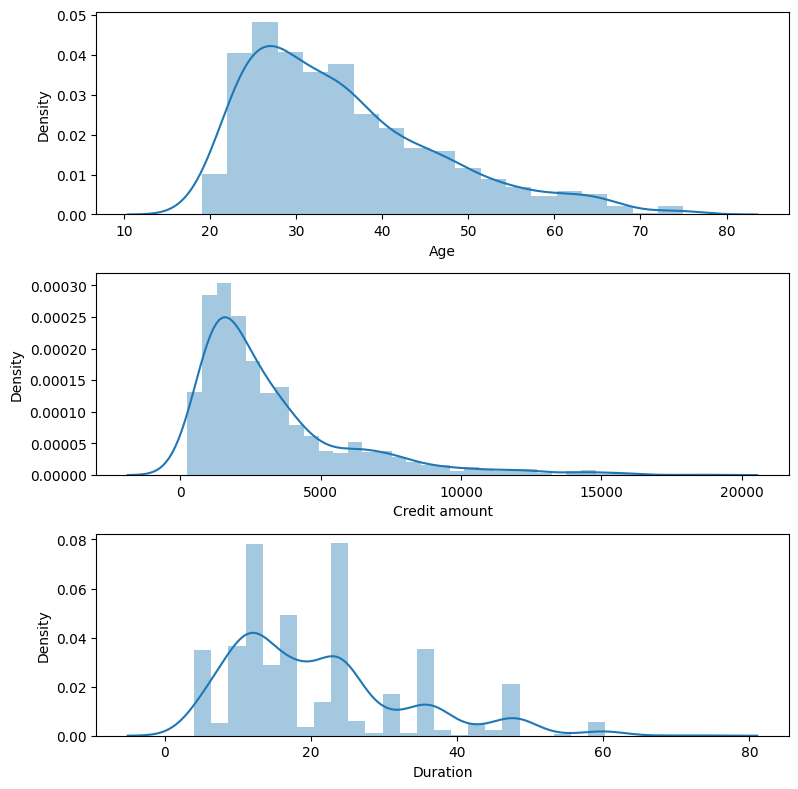

In [143]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 8))
sns.distplot(data['Age'], ax=ax1)
sns.distplot(data['Credit amount'], ax=ax2)
sns.distplot(data['Duration'], ax=ax3)
plt.tight_layout()

Посмотрим на корреляцию признаков

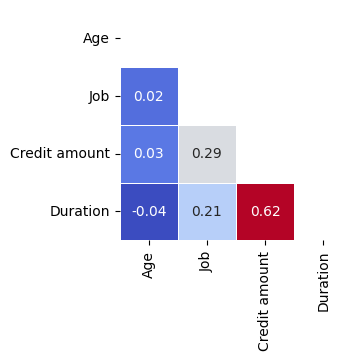

In [144]:
plt.figure(figsize=(3, 3))
mask = np.triu(data.corr())
sns.heatmap(data.corr(), annot=True, cbar=False, linewidths=.5, fmt='.2f', cmap='coolwarm', mask=mask)
plt.show()

Закодируем категориальные признаки с помощью LabelEncoder

In [145]:
cat_columns = data.select_dtypes(include='object').columns.tolist()
cat_columns

['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']

In [146]:
le = LabelEncoder()
for col in cat_columns:
    data[col] = le.fit_transform(data[col])

In [147]:
data.head(2)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,1,2,1,4,0,1169,6,5
1,22,0,2,1,0,1,5951,48,5


In [148]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Age               1000 non-null   int64
 1   Sex               1000 non-null   int64
 2   Job               1000 non-null   int64
 3   Housing           1000 non-null   int64
 4   Saving accounts   1000 non-null   int64
 5   Checking account  1000 non-null   int64
 6   Credit amount     1000 non-null   int64
 7   Duration          1000 non-null   int64
 8   Purpose           1000 non-null   int64
dtypes: int64(9)
memory usage: 70.4 KB


Теперь нужно выполнить масштабирование данных, например с помощью MinMaxScaler.

Это очень важная процедура, так как алгоритмы кластеризации используют Эвклидову норму для определения расстояния между объектами. Если данные не будут отмасштабируемы, L2-норма будет посчитана не верно! 

In [149]:
scaler = MinMaxScaler()

In [150]:
X_scaled = scaler.fit_transform(data)

In [151]:
data_scaled = pd.DataFrame(X_scaled, columns=data.columns)

In [152]:
data_scaled.head(3)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0.857143,1.0,0.666667,0.5,1.0,0.0,0.050567,0.029412,0.714286
1,0.053571,0.0,0.666667,0.5,0.0,0.5,0.313690,0.647059,0.714286
2,0.535714,1.0,0.333333,0.5,0.0,0.5,0.101574,0.117647,0.428571


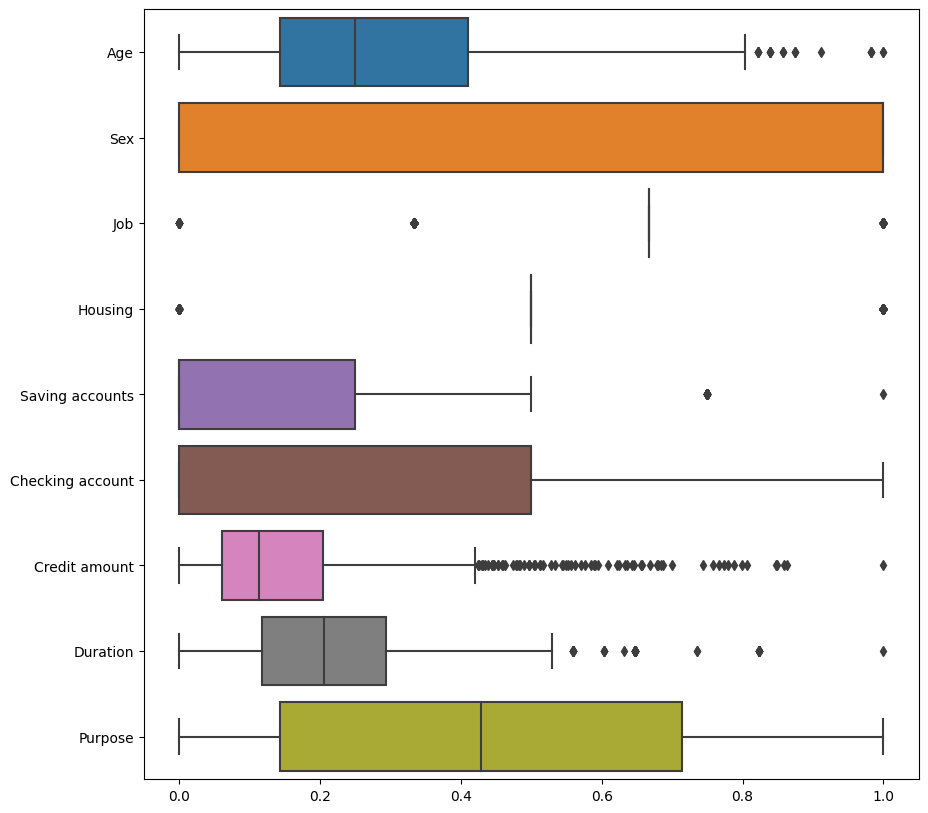

In [153]:
plt.figure(figsize=(10,10))
sns.boxplot(data=data_scaled, orient='h')
plt.show()

#Снижение размерности для визуализации

# TSNE

In [154]:
tsne = TSNE(n_components=2, random_state=10)

In [155]:
X_tsne = tsne.fit_transform(X_scaled)

In [156]:
print(X_scaled.shape)
print(X_tsne.shape)

(1000, 9)
(1000, 2)


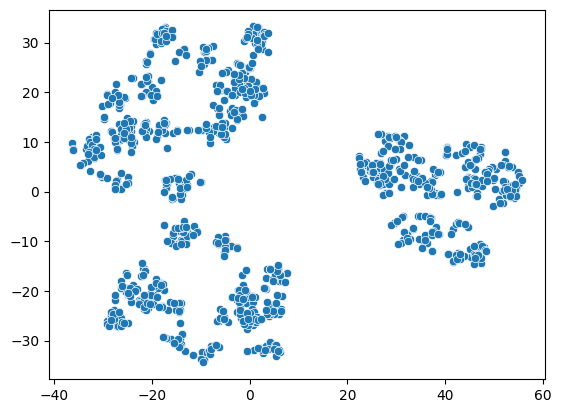

In [169]:
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1]);

# Clustering

# K-means

In [157]:
inertia = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, n_init='auto', random_state=10).fit(X_scaled)
    labels = kmeans.labels_
    inertia_i = kmeans.inertia_
    inertia.append(inertia_i)

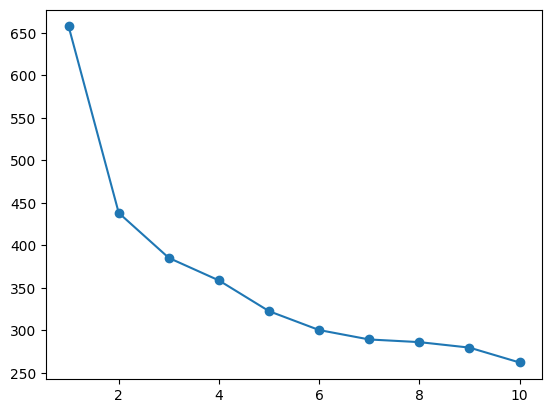

In [158]:
plt.plot(range(1,11), inertia, marker='o');

In [159]:
D = []
for i in range(1,9):
    Di = (inertia[i] - inertia[i+1])/(inertia[i-1] - inertia[i])
    D.append(Di)

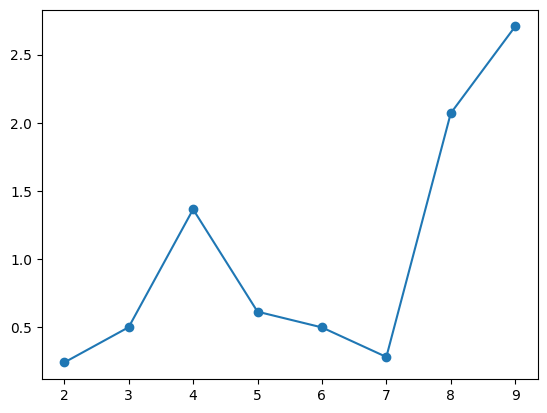

In [160]:
plt.plot(range(2,10), D, marker='o');

In [210]:
kmeans = KMeans(n_clusters=6, n_init='auto', random_state=10).fit(X_scaled)
labels = kmeans.labels_

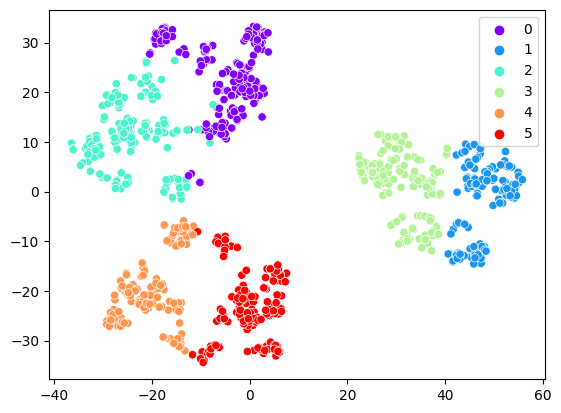

In [211]:
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=labels, palette='rainbow');

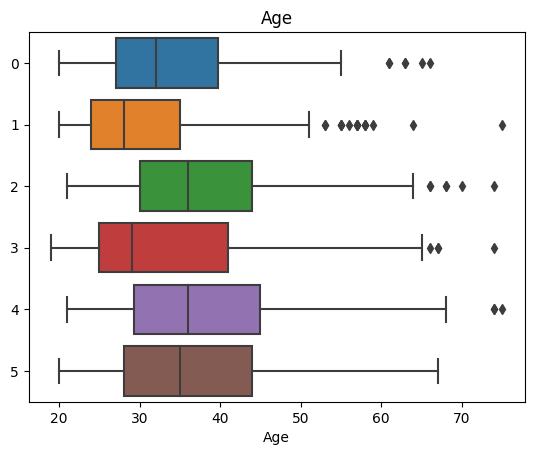

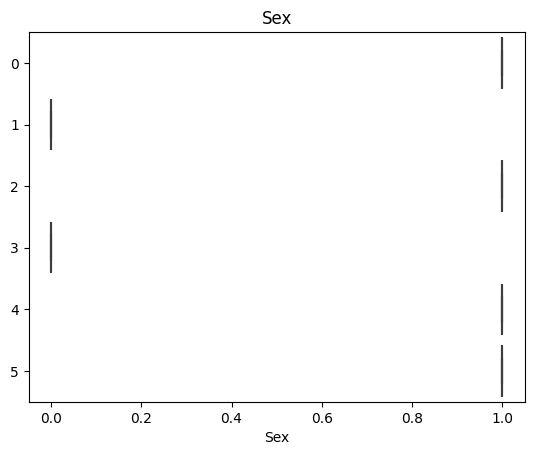

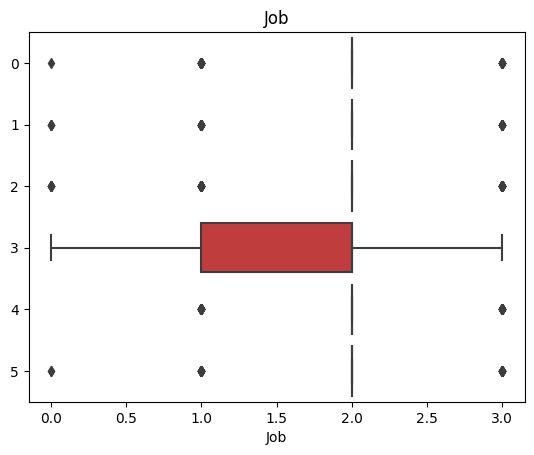

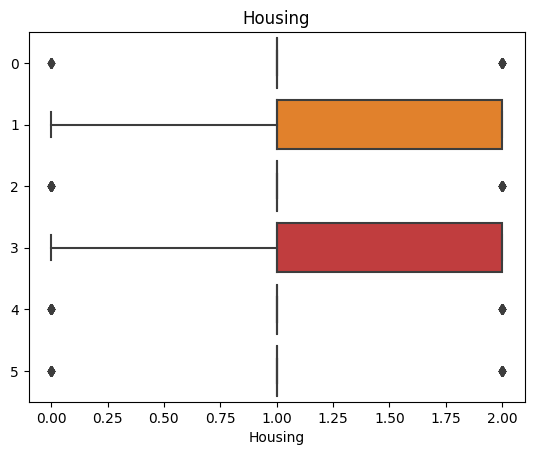

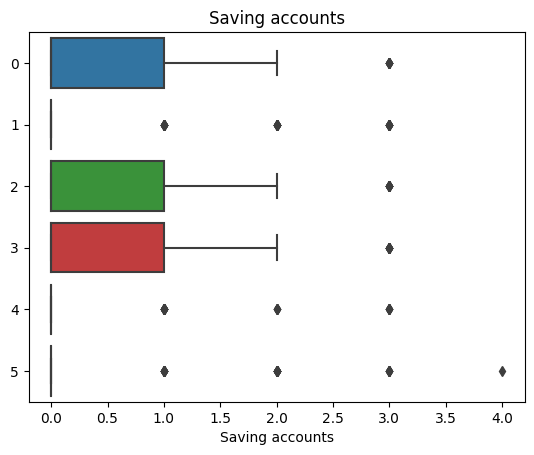

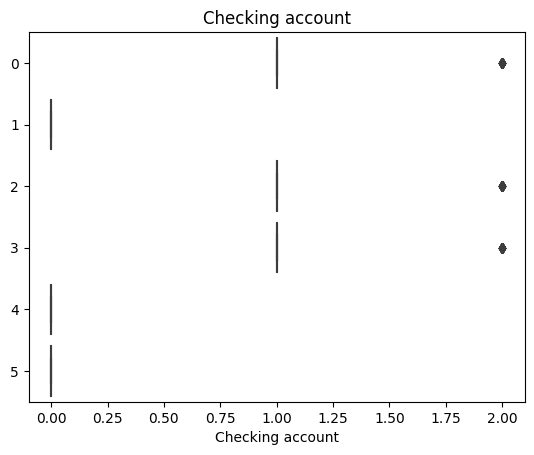

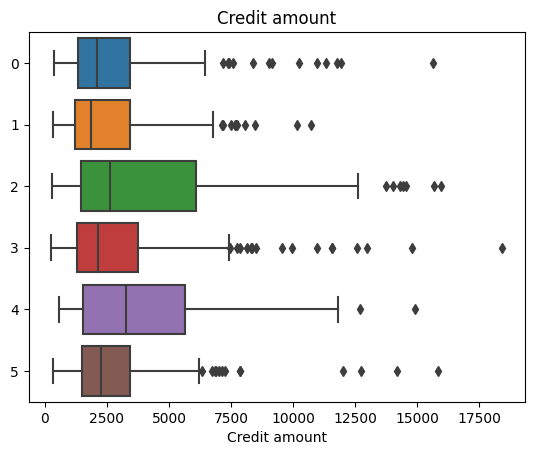

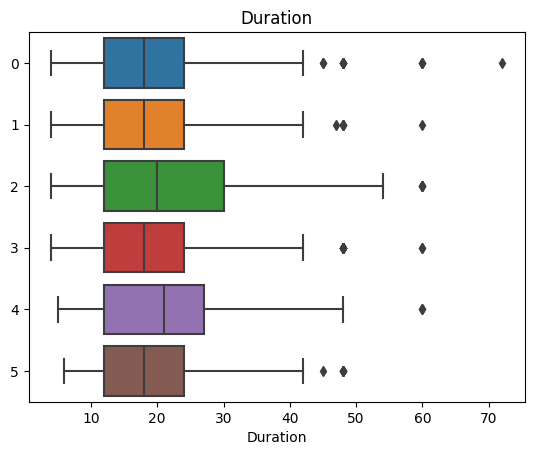

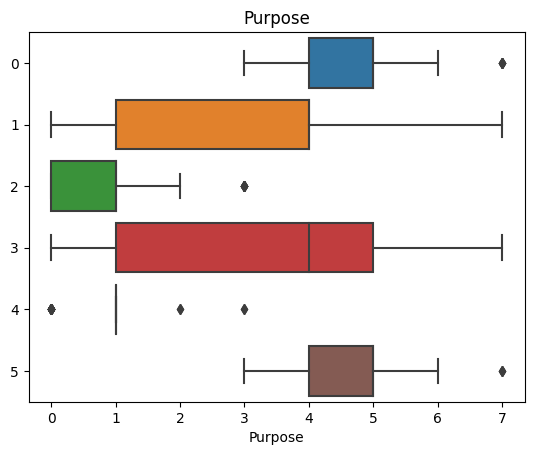

In [186]:
for col in data.columns:
    sns.boxplot(data=data, x=col, y=labels, orient='h')
    plt.title(col)
    plt.show();

In [195]:
data.groupby('Purpose').median().round(2)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration
Purpose,,,,,,,,
0,33.0,1.0,2.0,1.0,0.0,1.0,3161.0,24.0
1,35.0,1.0,2.0,1.0,0.0,1.0,2679.0,18.0
2,28.0,0.5,2.0,1.0,0.0,0.5,1249.0,13.5
3,36.0,1.0,2.0,1.0,0.0,1.0,1597.0,12.0
4,30.0,1.0,2.0,1.0,0.0,0.0,2578.0,18.0
5,32.0,1.0,2.0,1.0,0.0,1.0,1890.0,18.0
6,33.5,1.0,2.0,1.0,0.0,1.0,1749.0,16.5
7,39.5,1.0,3.0,1.0,0.0,1.0,6948.0,24.0


# AgglomerativeClustering

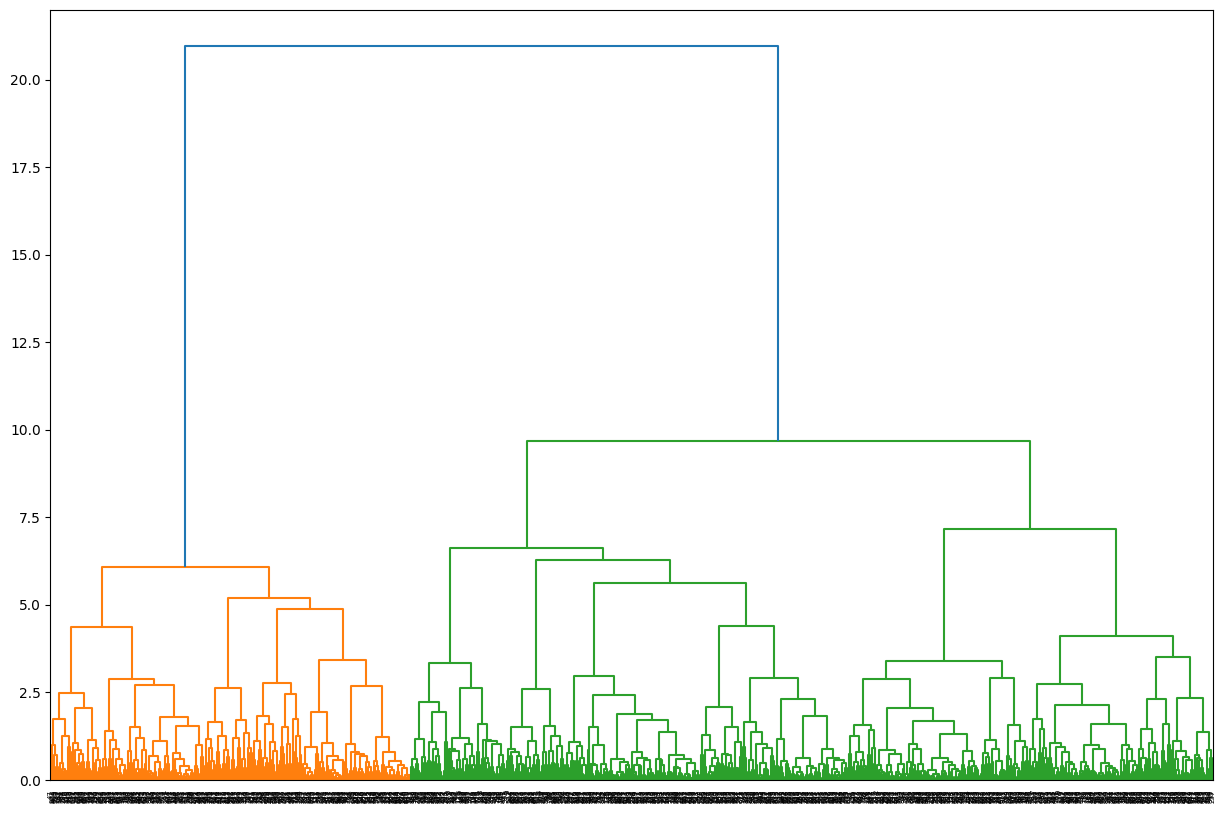

In [198]:
plt.figure(figsize=(15,10))
linkage_ = linkage(X_scaled, method='ward')
dendrogram_ = dendrogram(linkage_)

In [200]:
silhouette = []
for i in tqdm(range(2,11)):
    agg = AgglomerativeClustering(n_clusters=i).fit(X_scaled)
    labels = agg.labels_
    score = silhouette_score(X_scaled, labels)
    silhouette.append(score)

100%|██████████| 9/9 [00:00<00:00, 12.76it/s]


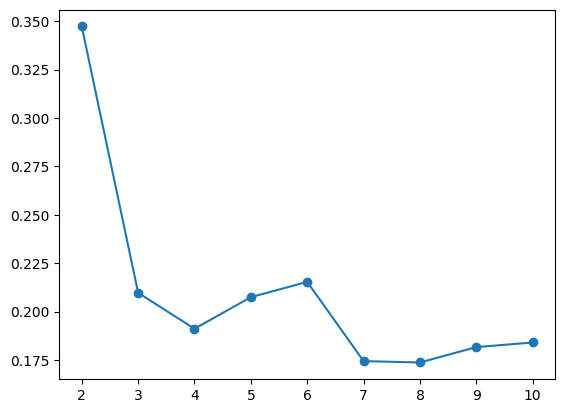

In [201]:
plt.plot(range(2,11), silhouette, marker='o');

In [213]:
agg = AgglomerativeClustering(n_clusters=3).fit(X_scaled)
labels = agg.labels_

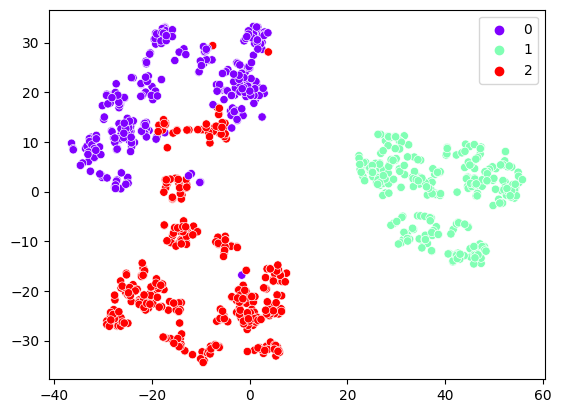

In [214]:
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=labels, palette='rainbow');

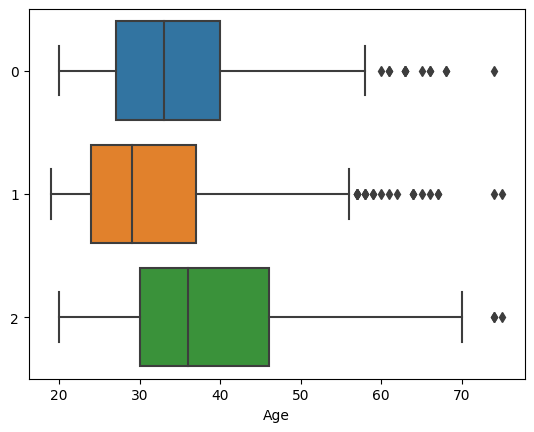

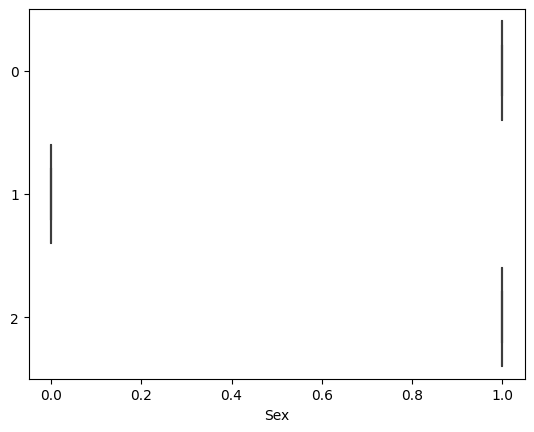

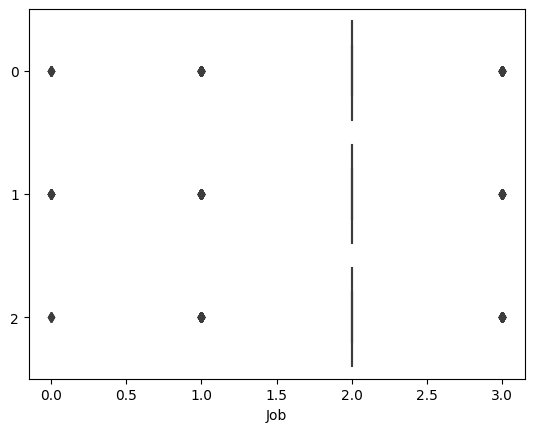

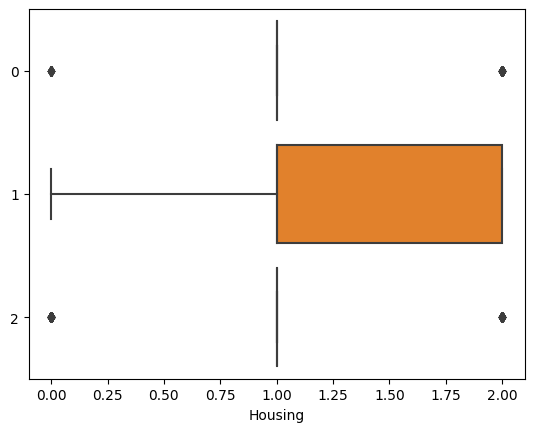

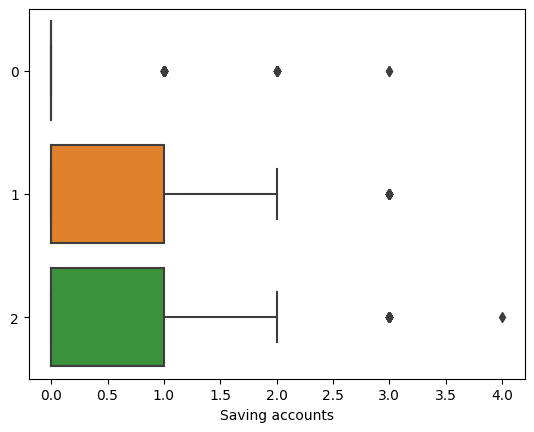

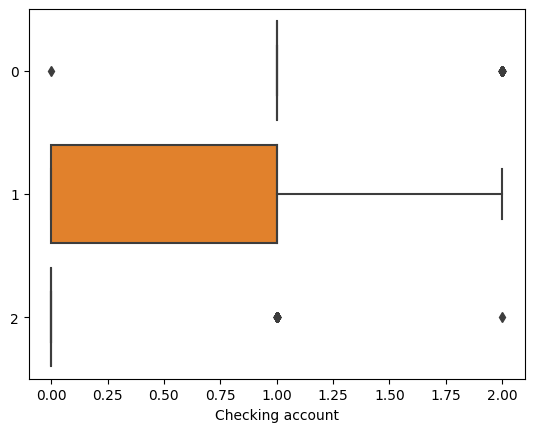

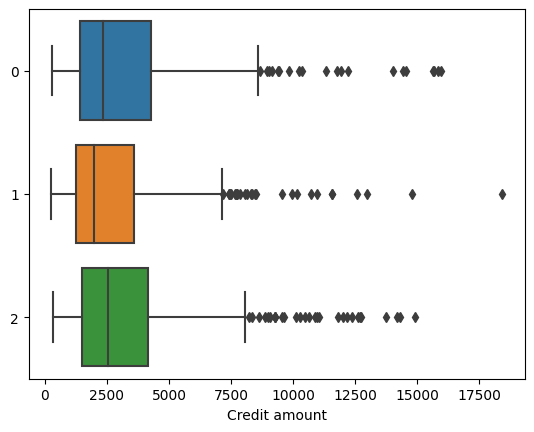

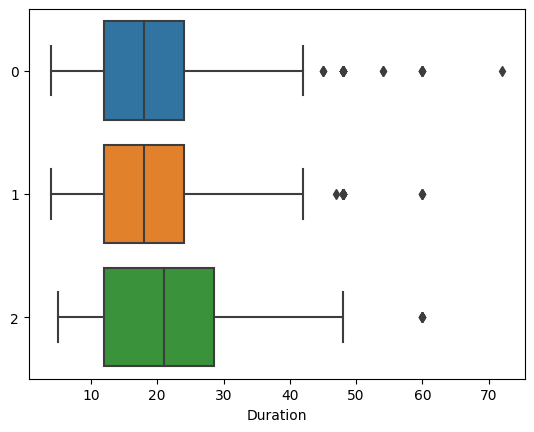

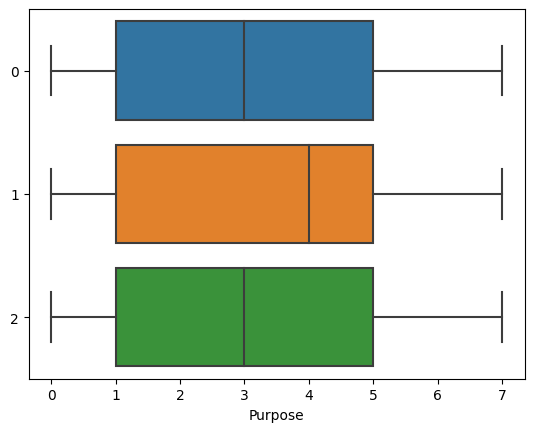

In [218]:
for col in data.columns:
    sns.boxplot(data=data, x=col, y=labels, orient='h')
    plt.show()

In [219]:
data.groupby('Purpose').median().round(2)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration
Purpose,,,,,,,,
0,33.0,1.0,2.0,1.0,0.0,1.0,3161.0,24.0
1,35.0,1.0,2.0,1.0,0.0,1.0,2679.0,18.0
2,28.0,0.5,2.0,1.0,0.0,0.5,1249.0,13.5
3,36.0,1.0,2.0,1.0,0.0,1.0,1597.0,12.0
4,30.0,1.0,2.0,1.0,0.0,0.0,2578.0,18.0
5,32.0,1.0,2.0,1.0,0.0,1.0,1890.0,18.0
6,33.5,1.0,2.0,1.0,0.0,1.0,1749.0,16.5
7,39.5,1.0,3.0,1.0,0.0,1.0,6948.0,24.0


# DBSCAN

In [220]:
def dbscan_clustering(eps_range, X):
    eps_range = eps_range
    silhouette = []
    clusters = []
    for i in tqdm(eps_range):
        dbscan = DBSCAN(eps=i).fit(X)
        labels = dbscan.labels_
        uniq_labels = np.unique(labels)
        n_clusters = len(uniq_labels[uniq_labels != -1])
        if n_clusters > 1:
            score = silhouette_score(X, labels)
        else:
            score = 0
        silhouette.append(score)
        clusters.append(n_clusters)
        
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.plot(eps_range, silhouette, marker='o', color=color)
    ax1.set_xlabel('eps')
    ax1.set_ylabel('silhouette', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.plot(eps_range, clusters, marker='o', color=color)
    ax2.set_ylabel('n_clusters', color=color)  
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

100%|██████████| 90/90 [00:10<00:00,  8.34it/s]


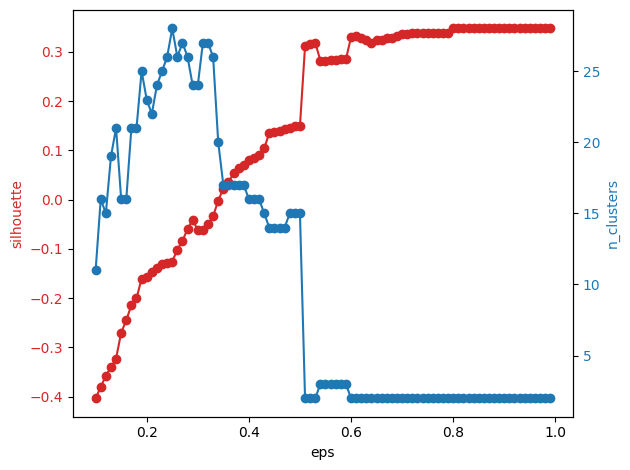

In [221]:
eps_range = np.arange(0.1, 1, 0.01)
dbscan_clustering(eps_range, X_scaled)

100%|██████████| 40/40 [00:03<00:00, 10.37it/s]


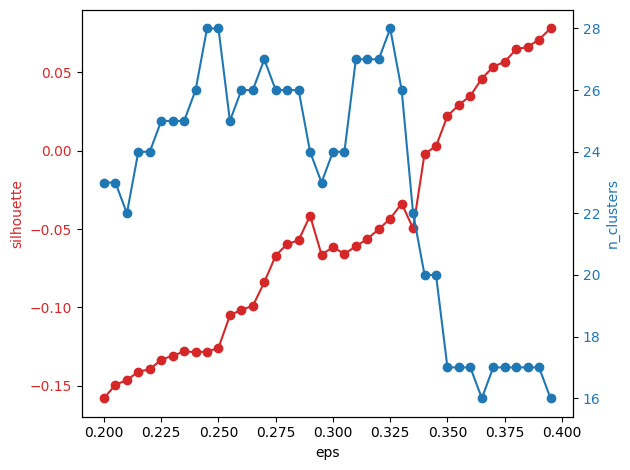

In [223]:
eps_range = np.arange(0.2, 0.4, 0.005)
dbscan_clustering(eps_range, X_scaled)

100%|██████████| 15/15 [00:01<00:00,  9.94it/s]


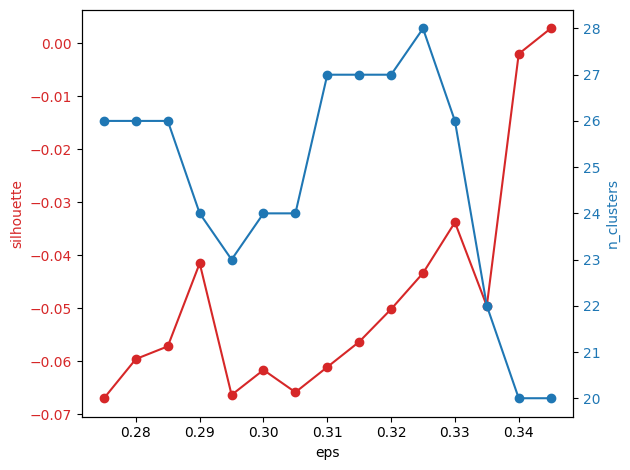

In [224]:
eps_range = np.arange(0.275, 0.350, 0.005)
dbscan_clustering(eps_range, X_scaled)

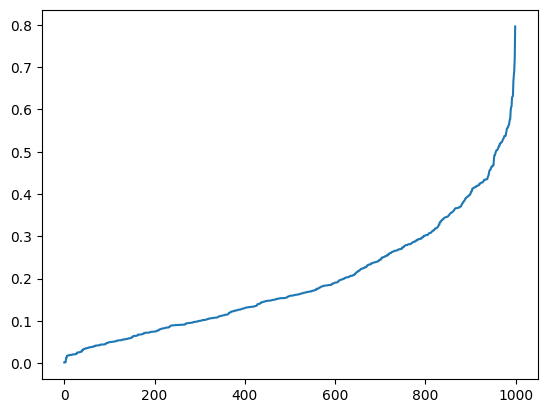

In [226]:
neighbors = NearestNeighbors(n_neighbors=5)
nbrs = neighbors.fit(X_scaled)
distance, indices = nbrs.kneighbors(X_scaled)

distance = np.sort(distance, axis=0)
distance = distance[:,1]
plt.plot(distance);

In [227]:
dbscan = DBSCAN(eps=0.33).fit(X_scaled)
labels = dbscan.labels_

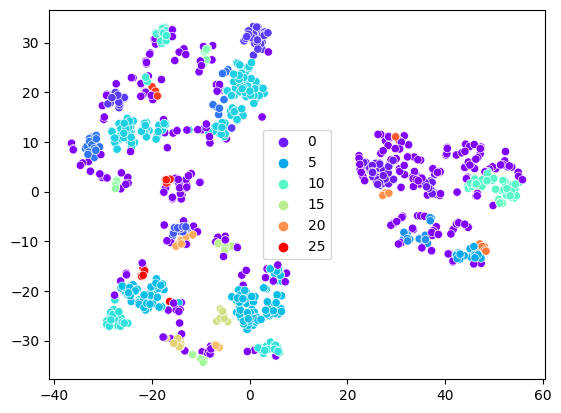

In [228]:
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=labels, palette='rainbow');

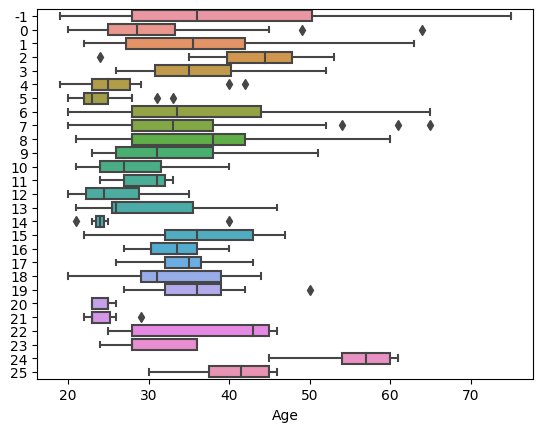

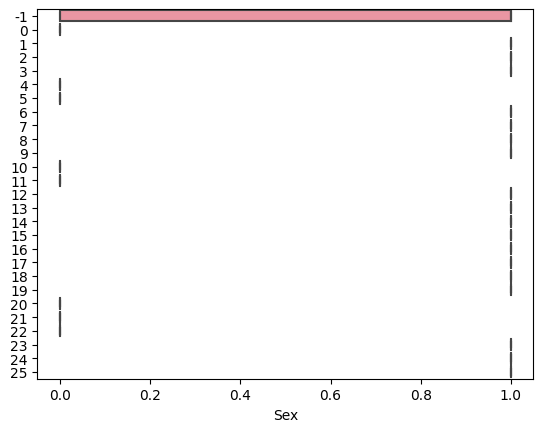

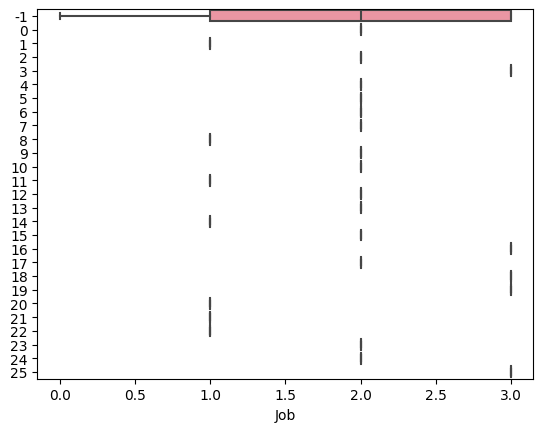

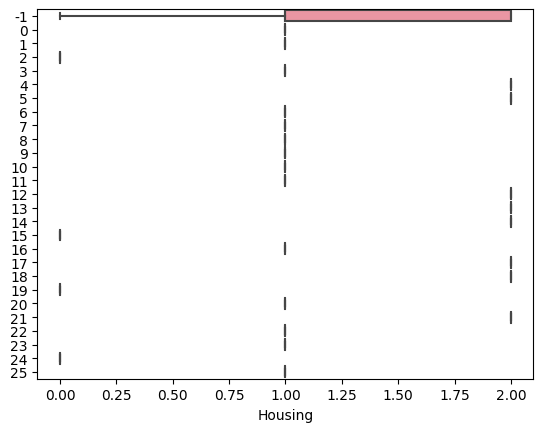

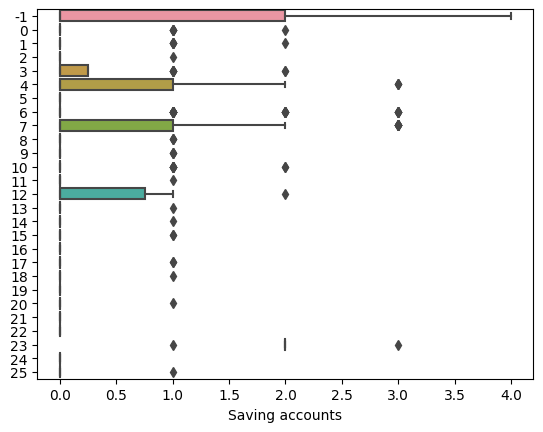

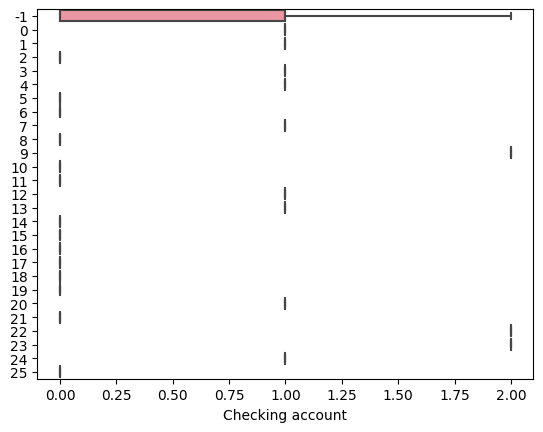

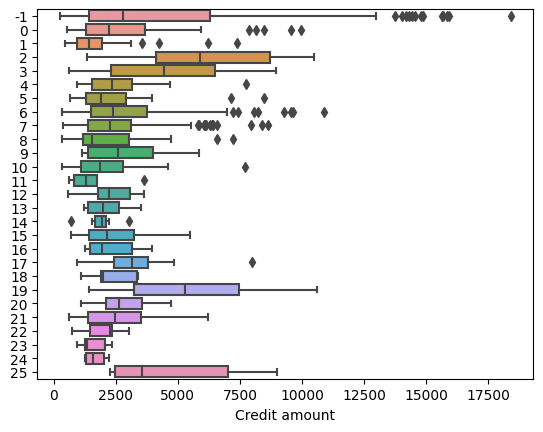

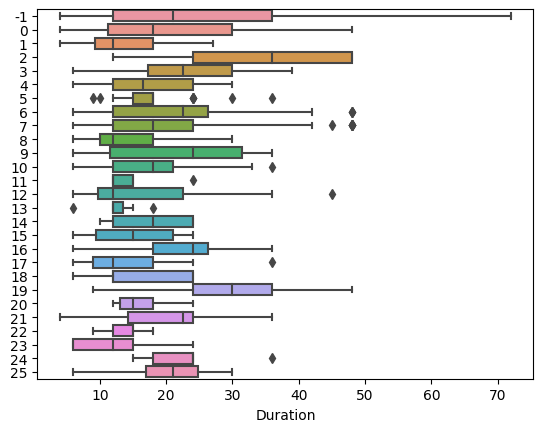

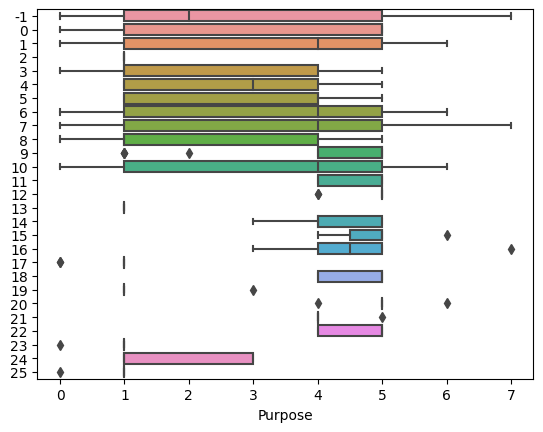

In [229]:
for col in data.columns:
    sns.boxplot(data=data, x=col, y=labels, orient='h')
    plt.show();

In [230]:
data.groupby('Purpose').median().round(2)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration
Purpose,,,,,,,,
0,33.0,1.0,2.0,1.0,0.0,1.0,3161.0,24.0
1,35.0,1.0,2.0,1.0,0.0,1.0,2679.0,18.0
2,28.0,0.5,2.0,1.0,0.0,0.5,1249.0,13.5
3,36.0,1.0,2.0,1.0,0.0,1.0,1597.0,12.0
4,30.0,1.0,2.0,1.0,0.0,0.0,2578.0,18.0
5,32.0,1.0,2.0,1.0,0.0,1.0,1890.0,18.0
6,33.5,1.0,2.0,1.0,0.0,1.0,1749.0,16.5
7,39.5,1.0,3.0,1.0,0.0,1.0,6948.0,24.0


Я считаю, что самый похожий на правду выдал алгоритм AgglomerativeClustering